In [20]:
import yt
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

yt.set_log_level("error")
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams["text.usetex"] = True
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3.5
mpl.rcParams["xtick.direction"] = "out"
mpl.rcParams["ytick.direction"] = "out"
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.fontsize"] = "small"

In [21]:
def format_axes(ax, xlab):
    ax[0,0].set_xlabel(xlab)
    ax[0,1].set_xlabel(xlab)
    ax[1,0].set_xlabel(xlab)
    ax[1,1].set_xlabel(xlab)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    ax[0,0].set_ylabel("Density, $\\rho$")
    ax[0,1].set_ylabel("Velocity, $v$")
    ax[1,0].set_ylabel("Pressure, $p$")
    ax[1,1].set_ylabel("Specific internal energy, $\epsilon$")

def get_conservative_field_names(dim):
    fields = ["x", "density", "mom_x", "energy"]
    if dim >= 2:
        fields.append("y")
        fields.append("mom_y")
    if dim >= 3:
        fields.append("z")
        fields.append("mom_z")
    return fields

def get_ray(adiabatic, epsilon, rot, dim, ds):
    rot = np.deg2rad(rot)
    fields = get_conservative_field_names(dim)
    if dim == 1:
        ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0]).to_dataframe(fields)
    else:
        ray = ds.ray([0, 0.5 - 0.5*np.tan(rot), 0], [1, 0.5 + 0.5*np.tan(rot), 0]).to_dataframe(fields)
    size = np.array(ray["x"]).size
    if (dim < 2):
        ray["mom_y"] = np.zeros(size)
        ray["y"] = np.zeros(size)
    if (dim < 3):
       ray["mom_z"] = np.zeros(size)
       ray["z"] = np.zeros(size)

    if (dim == 1):
        ray["d"] = ray["x"]
    else:
        ray["d"] = (ray["x"] - 0.5)*np.cos(rot) + (ray["y"] - 0.5)*np.sin(rot) + 0.5
    ray["mom"] = np.sqrt(ray["mom_x"] * ray["mom_x"] + ray["mom_y"] * ray["mom_y"] + ray["mom_z"] * ray["mom_z"])
    ray["vel"] = ray["mom"] / ray["density"] * np.sign(ray["mom_x"])
    ray["int_energy"] = (ray["energy"] - 0.5 * epsilon * ray["mom"] * ray["mom"] / ray["density"]) / ray["density"]
    ray["pressure"] = (adiabatic - 1) * ray["density"] * ray["int_energy"]
    return ray


def plot_four(ray, ax, fmt, label, **kwargs):    
    ax[0,0].plot(ray["d"],ray["density"],fmt,label=label, **kwargs)
    ax[0,1].plot(ray["d"],ray["vel"],fmt,label=label, **kwargs)
    ax[1,0].plot(ray["d"],ray["pressure"],fmt,label=label, **kwargs)
    ax[1,1].plot(ray["d"],ray["int_energy"],fmt,label=label, **kwargs)

# Takes an approximate solution and an exact solution with different resolutions and return an array of errors
def get_error(approx_soln, approx_x, exact_soln, exact_x):
    assert(approx_soln.size == approx_x.size)
    assert(exact_soln.size == exact_x.size)
    exact_interp = np.interp(approx_x, exact_x, exact_soln, np.NAN, np.NAN)
    return approx_soln - exact_interp

def get_dx(soln):
    return soln["x"][1] - soln["x"][0]

def error_norm(error, dx, ord):
    if (ord == np.inf):
        return np.abs(error).max()
    return np.power(np.power(np.abs(error), ord).sum() * dx.prod(), 1/ord)

def add_inset(x1,x2,y1,y2,pos,ax):
    axins = ax.inset_axes(
            pos,
            xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    lines = ax.lines
    for line in lines:
        axins.plot(line.get_xdata(), line.get_ydata(), c=line.get_color(), marker=line.get_marker(), markersize=line.get_markersize(), linestyle=line.get_linestyle(), fillstyle=line.get_fillstyle(), markeredgewidth=line.get_markeredgewidth())
    ax.indicate_inset_zoom(axins, edgecolor="black")

# Live plots
## 1D tests

/tmp/ipykernel_31138/2725808094.py:113: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_31138/2725808094.py:113: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


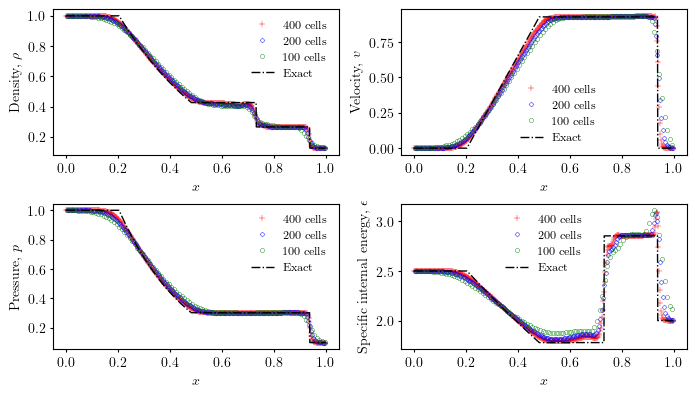

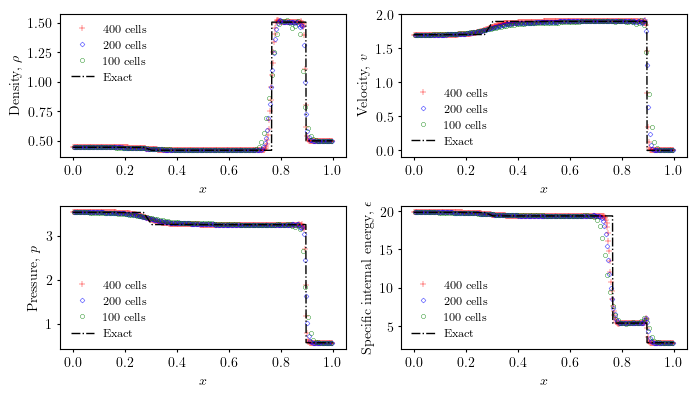

In [30]:
DIRECTORIES = ["build/Exec/RiemannProblem/output/test1/*",      #0
               "build/Exec/RiemannProblem/output/test1-slow/*", #1
               "build/Exec/RiemannProblem/output/test2/*",      #2
               "build/Exec/RiemannProblem/output/test3/*",      #3
               "build/Exec/RiemannProblem/output/test4/*",      #4
               "build/Exec/RiemannProblem/output/test5/*",      #5
               "build/Exec/RiemannProblem/output/test6/*",      #6
               "build/Exec/RiemannProblem/output/lax/*",        #7
               "build/Exec/RiemannProblem/output/contact/*",    #8
               "build/Exec/SinProblem/output/*",                #9
               "build/Exec/RiemannProblem2D/output/test1/35deg/*"] #10

# DIRECTORIES = ["build_gpu/Exec/RiemannProblem/output/test1/*",
#                "build_gpu/Exec/RiemannProblem/output/test2/*",
#                "build_gpu/Exec/RiemannProblem/output/test3/*",
#                "build_gpu/Exec/RiemannProblem/output/test4/*",
#                "build_gpu/Exec/RiemannProblem/output/test5/*",
#                "build_gpu/Exec/RiemannProblem/output/test6/*",
#                "build_gpu/Exec/SinProblem/output/*",
#                "build_gpu/Exec/RiemannProblem2D/output/test1/35deg/*"]

EXACT_SOLN_EXISTS = [True, True, True, True, True, True, True, True, True, True, True]
COMPUTE_CONVERGENCE = [False, False, False, False, False, False, False, False, True, False]
NAMES = ["toro1", "toro1-slow", "toro2", "toro3", "toro4", "toro5", "incident shocks", "lax test", "advected sin", "toro1, 35deg"]
ADIABATICS = [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
EPSILONS = [1, 1e-6, 1, 1, 1, 1, 1, 1, 1, 1]
DIMS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
ROTS = [0, 0, 0, 0, 0, 0, 0, 0, 0, 35]

exact_fmt = "k-."
res_fmts = ["go", "bD", "r+", "c^", "yD", "ms"]
marker_sizes = [3, 2.5, 4, 4, 4, 4]

# tests_to_plot = [0,2,3,4,5,6,7]
tests_to_plot = [0,7]

for i in tests_to_plot:
    TESTCASE = DIRECTORIES[i]
    SUBRUN_DIRS = sorted(glob.glob(TESTCASE))
    if (len(SUBRUN_DIRS) == 0):
        print (f"Cannot find results with pattern {DIRECTORIES[i]}")
        continue
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt?????"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    EXACT_SOLUTION = SUBRUN_DIRS[0] + "/pltEXACT_SOLN"
    adiabatic = ADIABATICS[i]
    epsilon = EPSILONS[i]
    dim = DIMS[i]
    rot = ROTS[i]
    fig, ax = plt.subplots(2, 2, figsize=(7,4))

    # fig.suptitle(NAMES[i])

    num_solns = {}

    # plot numerical solution
    for ifile, plotfile in reversed(list(enumerate(SUBRUN_FINAL_OUTPUTS))):
        ds = yt.load(plotfile)
        label = f"{ds.domain_dimensions[0]} cells"

        # ray
        ray = get_ray(adiabatic, epsilon, rot, dim, ds)
        plot_four(ray,ax,res_fmts[ifile],label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
        if COMPUTE_CONVERGENCE[i]:
            num_solns[ds.domain_dimensions[0]] = ray

    # plot exact solution
    if (EXACT_SOLN_EXISTS[i]):
        label = "Exact"
        ds = yt.load(EXACT_SOLUTION)
        exact_ray = get_ray(adiabatic, epsilon, 0, 1, ds)
        plot_four(exact_ray,ax,exact_fmt,label)

    if (COMPUTE_CONVERGENCE[i]):
        assert(EXACT_SOLN_EXISTS[i])
        print(NAMES[i] + " convergence:")

        df = pd.DataFrame(columns=["dx", "Density L1", "Density L2", "Density Linf"])
        for res in sorted(num_solns.keys()):
            soln = num_solns[res]
            soln["error_density"] = get_error(soln["density"], soln["x"], exact_ray["density"], exact_ray["x"])
            dx = get_dx(soln)
            ndx = np.array([dx])
            L1 = error_norm(soln["error_density"],ndx,1)
            L2 = error_norm(soln["error_density"],ndx,2)
            Linf = error_norm(soln["error_density"],ndx,np.inf)
            df.loc[res] = [dx, L1, L2, Linf]
        df.insert(2, "L1 order", np.log(df["Density L1"] / df["Density L1"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(4, "L2 order", np.log(df["Density L2"] / df["Density L2"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(6, "Linf order", np.log(df["Density Linf"] / df["Density Linf"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        print(df)

    # make plots pretty
    xlab = "$x$"
    format_axes(ax, xlab)

    if i == 0:
        ax[0,1].legend(loc=[0.4,0.05])
        # inset axes....
        # add_inset(0.7,0.76,0.2,0.5, [0.05, 0.05, 0.4, 0.4], ax[0,0])
        # add_inset(0.68, 0.78, 1.7, 3, [0.05, 0.05, 0.4, 0.4], ax[1,1])
        # add_inset(0.4,0.55,0.85,0.95,[0.05,0.25,0.4,0.4],ax[0,1])
    
    if i == 2:
        # inset axes....
        add_inset(0.4,0.6,0,0.05,[0.55,0.05,0.4,0.4],ax[0,0])
        add_inset(0.4,0.6,-0.2,0.2,[0.55,0.05,0.4,0.4],ax[0,1])
    
    # if i == 4:
    #     add_inset(0.52,0.54,ax[0,0].get_ylim()[0],1.3,[0.05,0.05,0.4,0.4],ax[0,0])

    fig.tight_layout(pad=0.8)
    fig.savefig(f"outputs/{NAMES[i]}_BP_REUSE_ORIGINALLAP.svg", dpi=300)
    fig.show()

# 2D tests
## Isentropic vortex - convergence

In [13]:
"""
Takes a yt box/region/data container and figures out the dimension of the problem
"""
def get_dim(data):
    assert(data.shape[0] > 1)
    if data.shape[1] == 1:
        assert(data.shape[2] == 1)
        return 1
    if data.shape[2] == 1:
        return 2
    return 3

"""
Takes a dataframe from and adds the primitive variables in
"""
def compute_primitives(data, dim, adiabatic):
    shape = data["x"].shape
    if dim < 2:
        data["y"] = np.zeros(shape)
        data["mom_y"] = np.zeros(shape)
    if dim < 3:
        data["z"] = np.zeros(shape)
        data["mom_z"] = np.zeros(shape)
    data["u"] = data["mom_x"] / data["density"]
    data["v"] = data["mom_y"] / data["density"]
    data["w"] = data["mom_z"] / data["density"]
    data["u_sq"] = data["u"] * data["u"] + data["v"] * data["v"] + data["w"] * data["w"]
    data["int_energy"] = (data["energy"] - 0.5 * data["density"] * data["u_sq"]) / data["density"]
    data["pressure"] = (adiabatic - 1) * (data["energy"] - 0.5 * data["density"] * data["u_sq"])

"""
Takes a yt data object and converts it to a DataFrame.
The fact I have to write this myself is very annoying, but the
to_dataframe() method provided by YT doesn't work for data in >1D...
"""
def to_dataframe(data):
    dim = get_dim(data)
    fields = get_conservative_field_names(dim)
    iterables = [range(0, data.shape[0]), range(0, data.shape[1]), range(0, data.shape[2])]
    index = pd.MultiIndex.from_product(iterables, names=["i","j","k"])
    entries = {}
    for field in fields:
        entries[field] = data[field].to_ndarray().flatten()
    return pd.DataFrame(entries, index=index)

"""
Takes the path to a plotfile and returns a DataFrame with primitive variables computed and its dimension
"""
def open_plotfile(plotfile, adiabatic):
    ds = yt.load(plotfile)
    data = ds.covering_grid(level=ds.max_level, left_edge=ds.domain_left_edge,dims=ds.domain_dimensions*ds.relative_refinement(0,ds.max_level))
    dim = get_dim(data)
    data = to_dataframe(data)
    compute_primitives(data, dim, adiabatic)
    return data, dim

"""
Computes the error norms for density, velocity and pressure using the plotfiles
provided and returns them in array form along with the cell spacing:

[dx, density L1, density L2, density Linf, u L1, u L2, u Linf, v L1, v L2, v Linf,
 w L1, w L2, w Linf, pressure L1, pressure L2, pressure Linf]
"""
def compute_error_norms(numerical_plotfile, exact_plotfile, adiabatic):
    # Load files
    num_data, dim = open_plotfile(numerical_plotfile, adiabatic)
    exact_data, exact_dim = open_plotfile(exact_plotfile, adiabatic)
    assert(num_data.shape == exact_data.shape)
    assert(dim == exact_dim)

    # Get dx (remember that the covered grid has constant cell spacing)
    dx = [num_data["x"][1,0,0]-num_data["x"][0,0,0]]
    if (dim >= 2):
        dx.append(num_data["y"][0,1,0]-num_data["y"][0,0,0])
    if (dim == 3):
        dx.append(num_data["z"][0,0,1]-num_data["z"][0,0,0])
    dx = np.array(dx)

    # Now we can start computing errors

    ## The row returned should match:
    ## ["dx", "density L1", "density L2", "density Linf", "u L1", "u L2", "u Linf",
    ##  "v L1", "v L2", "v Linf", "w L1", "w L2", "w Linf",
    ##  "pressure L1", "pressure L2", "pressure Linf"]

    ## Fields to calculate errors for.
    ## Note that even in 1D v and w have been populated with zeros
    fields = ["density", "u", "v", "w", "pressure"]
    ## This is the row we'll add to the dataframe passed to this function
    row = [dx[0]]
    for field in fields:
        error = num_data[field] - exact_data[field]
        row.append(error_norm(error, dx, 1))
        row.append(error_norm(error, dx, 2))
        row.append(error_norm(error, dx, np.inf))
    return row

"""
Parameters
----------
test_dir : test case directory with a glob, for instance \"./build/Exec/IsentropicVortex/output/2d/*\"
    where inside that directory is subdirectories \"100\", \"200\", etc
"""
def get_convergence_properties(test_dir, adiabatic):
    SUBRUN_DIRS = sorted(glob.glob(test_dir))
    if (len(SUBRUN_DIRS) == 0):
        print (f"Cannot find results with pattern {test_dir}")
        return
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt?????"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    EXACT_SOLUTIONS = [SUBRUN_DIR + "/pltEXACT_SOLN" for SUBRUN_DIR in SUBRUN_DIRS]
    error_norms = []
    for i in range(len(SUBRUN_FINAL_OUTPUTS)):
        error_norms.append(compute_error_norms(SUBRUN_FINAL_OUTPUTS[i], EXACT_SOLUTIONS[i], adiabatic))
    df = pd.DataFrame(columns=["dx", "density L1", "density L2", "density Linf",
                               "u L1", "u L2", "u Linf", "v L1", "v L2", "v Linf",
                               "w L1", "w L2", "w Linf", "pressure L1", "pressure L2",
                               "pressure Linf"], data=error_norms)

    fields = ["density", "u", "v", "w", "pressure"]
    for ifield, field in enumerate(fields):
        df.insert(6 * ifield + 2, field + " L1 order", np.log(df[field + " L1"] / df[field + " L1"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(6 * ifield + 4, field + " L2 order", np.log(df[field + " L2"] / df[field + " L2"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(6 * ifield + 6, field + " Linf order", np.log(df[field + " Linf"] / df[field + " Linf"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))

    return df



DIRECTORIES = ["./build/Exec/IsentropicVortex/output/2d/*", "./build/Exec/IsentropicVortex/output/3d/*"]

for dir in DIRECTORIES:
    df = get_convergence_properties(dir, 1.4)
    print(df)

         dx  density L1  density L1 order  density L2  density L2 order  \
0  0.625000    0.841430               NaN    0.201407               NaN   
1  0.312500    0.408936          1.040968    0.100352          1.005040   
2  0.156250    0.188612          1.078711    0.045317          1.076000   
3  0.078125    0.086342          1.094903    0.020379          1.101648   
4  0.039062    0.041890          1.082044    0.009735          1.092683   

   density Linf  density Linf order      u L1  u L1 order      u L2  ...  \
0      0.153295                 NaN  1.835673         NaN  0.465101  ...   
1      0.081639            0.908969  0.763217    1.266143  0.210062  ...   
2      0.042118            0.931893  0.336454    1.223914  0.098360  ...   
3      0.020898            0.958295  0.157452    1.181110  0.047061  ...   
4      0.010868            0.954528  0.079330    1.133074  0.024315  ...   

   w L2  w L2 order  w Linf  w Linf order  pressure L1  pressure L1 order  \
0   0.0        

## GPU/CPU comparison

In [6]:
"""
Parameters
----------
test_dir : test case directory with a glob, for instance \"./build/Exec/IsentropicVortex/output/2d/*\"
    where inside that directory is subdirectories \"100\", \"200\", etc
"""
def compare_tests(testdir1, testdir2, adiabatic):
    SUBRUN_DIRS1 = sorted(glob.glob(testdir1))
    if (len(SUBRUN_DIRS1) == 0):
        print (f"Cannot find results with pattern {testdir1}")
        return
    SUBRUN_FINAL_OUTPUTS1 = [sorted(glob.glob(SUBRUN_DIR1+"/plt?????"))[-1] for SUBRUN_DIR1 in SUBRUN_DIRS1]
    SUBRUN_DIRS2 = sorted(glob.glob(testdir2))
    if (len(SUBRUN_DIRS2) == 0):
        print (f"Cannot find results with pattern {testdir2}")
        return
    SUBRUN_FINAL_OUTPUTS2 = [sorted(glob.glob(SUBRUN_DIR2+"/plt?????"))[-1] for SUBRUN_DIR2 in SUBRUN_DIRS2]
    error_norms = []
    for i in range(len(SUBRUN_FINAL_OUTPUTS1)):
        error_norms.append(compute_error_norms(SUBRUN_FINAL_OUTPUTS1[i], SUBRUN_FINAL_OUTPUTS2[i], adiabatic))
    df = pd.DataFrame(columns=["dx", "density L1", "density L2", "density Linf",
                               "u L1", "u L2", "u Linf", "v L1", "v L2", "v Linf",
                               "w L1", "w L2", "w Linf", "pressure L1", "pressure L2",
                               "pressure Linf"], data=error_norms)
    print(df)

compare_tests("build/Exec/RiemannProblem/output/test1/*", "build_gpu/Exec/RiemannProblem/output/test1/*", 1.4)
# compare_tests("build/Exec/RiemannProblem/output/test2/*", "build_gpu/Exec/RiemannProblem/output/test2/*", 1.4)
# compare_tests("build/Exec/RiemannProblem/output/test3/*", "build_gpu/Exec/RiemannProblem/output/test3/*", 1.4)
# compare_tests("build/Exec/RiemannProblem/output/test4/*", "build_gpu/Exec/RiemannProblem/output/test4/*", 1.4)
# compare_tests("build/Exec/RiemannProblem/output/test5/*", "build_gpu/Exec/RiemannProblem/output/test5/*", 1.4)
compare_tests("build/Exec/IsentropicVortex/output/2d/*", "build_gpu/Exec/IsentropicVortex/output/2d/*", 1.4)

Cannot find results with pattern build_gpu/Exec/RiemannProblem/output/test1/*


AssertionError: 

## Temporary code

In [18]:
BASE_FILENAMES = ["./build/Exec/RiemannProblem/output/test1/100/plt",
             "./build/Exec/RiemannProblem/output/test2/100/plt",
             "./build/Exec/RiemannProblem/output/test3/100/plt",
             "./build/Exec/RiemannProblem/output/test4/100/plt",
             "./build/Exec/RiemannProblem/output/test5/100/plt",
             "./build/Exec/SinProblem/output/128/plt"]
FILENAMES = [filename + "?????" for filename in BASE_FILENAMES]
EXACT_SOLN_FILENAMES = [filename + "EXACT_SOLN" for filename in BASE_FILENAMES]

adiabatic = 1.4

/tmp/ipykernel_132741/4195412243.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


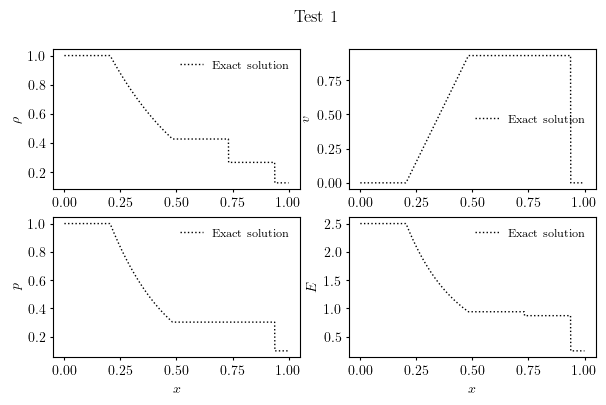

In [27]:
yt.set_log_level("error")
DIM = 1
# to_plot = [0,1,2,3,4]
to_plot = [0]
for i in to_plot:
    FILENAME = FILENAMES[i]
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(7,4))
    for ds in ts[11::100]:
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            ray = ds.ray([x_centre,ds.domain_left_edge[1].value,0], [x_centre,ds.domain_right_edge[1].value,0])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        time_label = f"t = {ds.current_time.value:.3f}"
        # time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        # num_fmt = "bx"
        num_fmt = ""
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    #
    # Plot exact solution
    #
    exact = yt.load(EXACT_SOLN_FILENAMES[i])
    ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    mom = np.array(ray["mom_x"])
    x = np.array(ray["x"])
    density = np.array(ray["density"])
    energy = np.array(ray["energy"])
    vel_x = mom / density
    pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    exact_label = "Exact solution"
    exact_fmt = "k:"

    ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")
    fig.savefig(f"outputs/{i+1}.svg")
    fig.show()

## Cylindrical Explosion

/tmp/ipykernel_21379/648381014.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


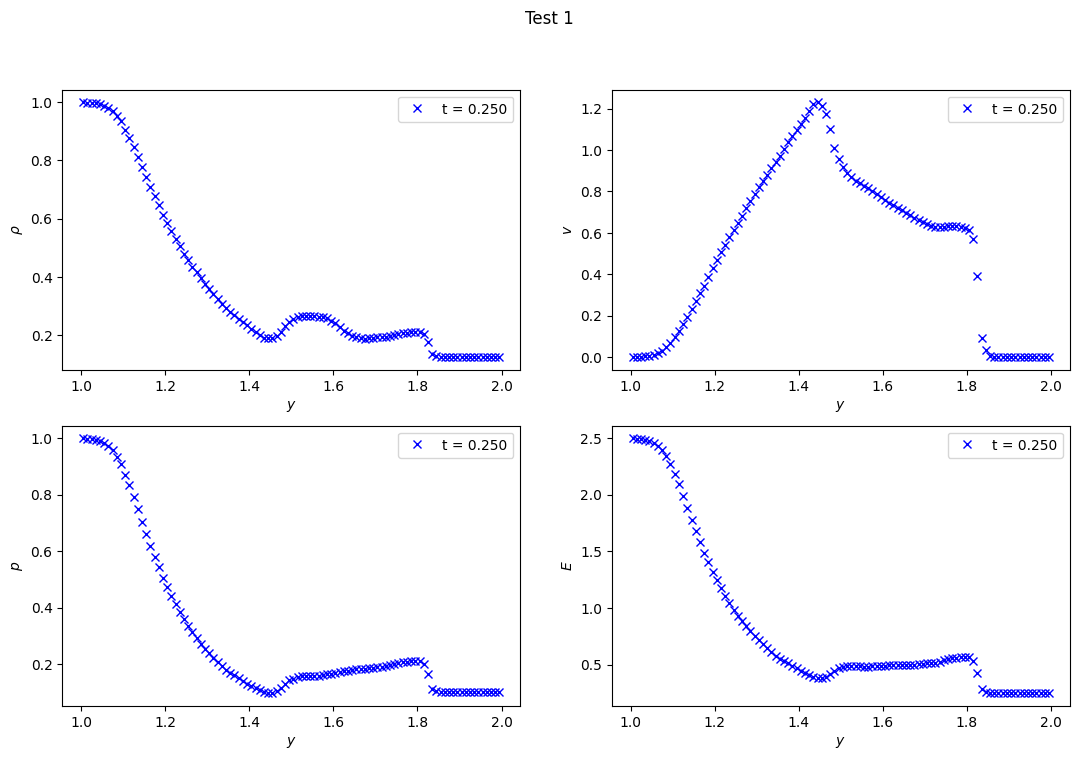

In [25]:
# BASE_FILENAMES = ["./outputs/cylindricalexplosion_200_3d/plt"]
# FILENAMES = [filename + "?????" for filename in BASE_FILENAMES]
FILENAMES = ["./outputs/cylindricalexplosion_200_3d/plt00065"]
# EXACT_SOLN_FILENAMES = [filename + "EXACT_SOLN" for filename in BASE_FILENAMES]

adiabatic = 1.4

yt.set_log_level("error")
DIM = 2
to_plot = [0]
for i in to_plot:
    FILENAME = FILENAMES[i]
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    # for ds in ts[-2:-1]:
    for ds in [ts]:
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            y_centre = (ds.domain_left_edge[1].value + ds.domain_right_edge[1].value)/2
            z_centre = (ds.domain_left_edge[2].value + ds.domain_right_edge[2].value)/2
            ray = ds.ray([x_centre,y_centre,z_centre], [x_centre,ds.domain_right_edge[1].value,z_centre])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        time_label = f"t = {ds.current_time.value:.3f}"
        # time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        # num_fmt = "bx"
        num_fmt = "bx"
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    # #
    # # Plot exact solution
    # #
    # exact = yt.load(EXACT_SOLN_FILENAMES[i])
    # ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    # mom = np.array(ray["mom_x"])
    # x = np.array(ray["x"])
    # density = np.array(ray["density"])
    # energy = np.array(ray["energy"])
    # vel_x = mom / density
    # pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    # exact_label = "Exact solution"
    # exact_fmt = "k:"

    # ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    # ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    # ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    # ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()

# Plotting existing results

/tmp/ipykernel_21379/4294276362.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


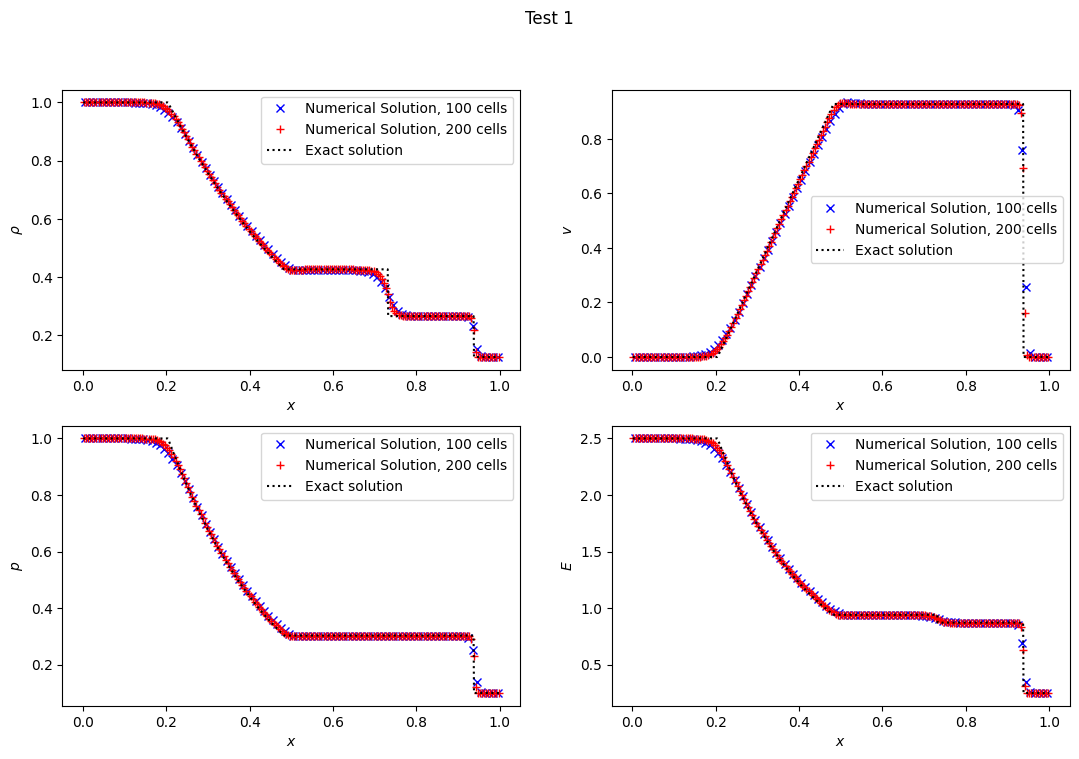

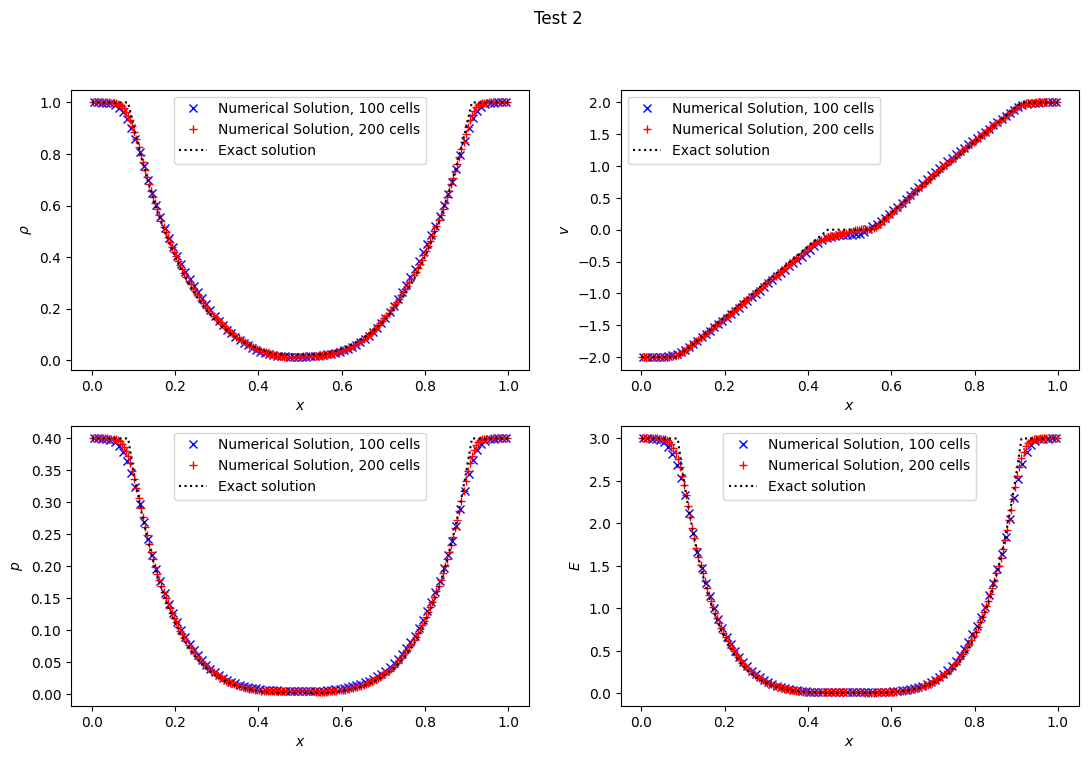

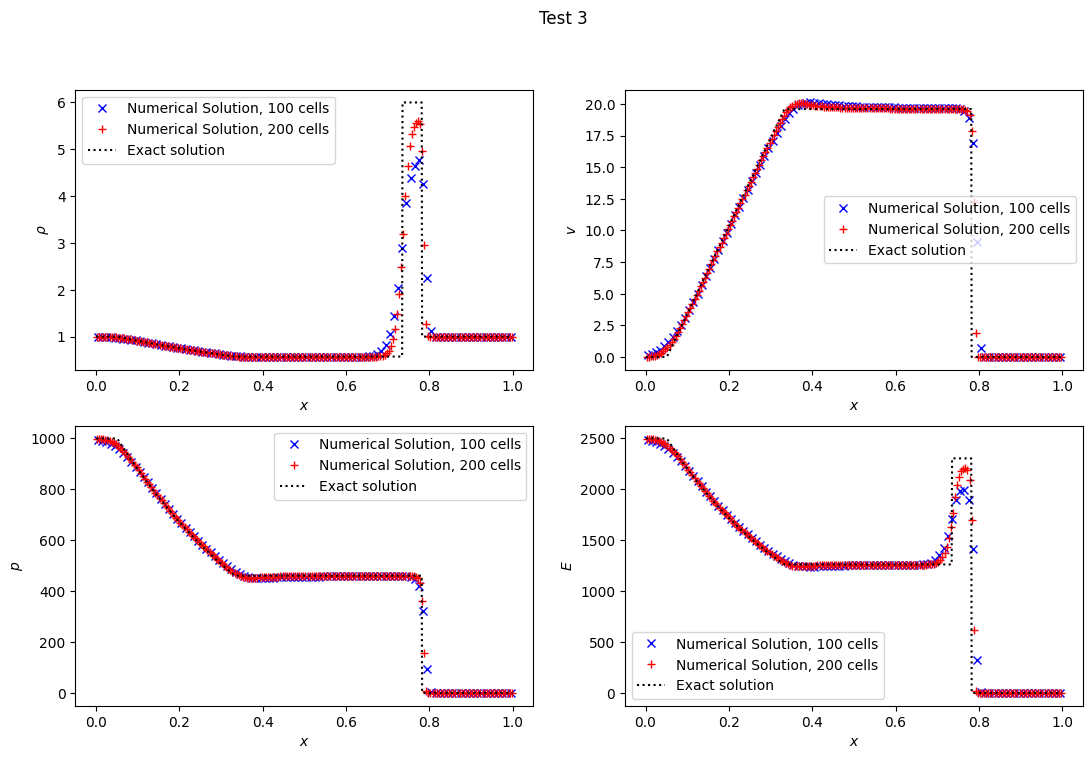

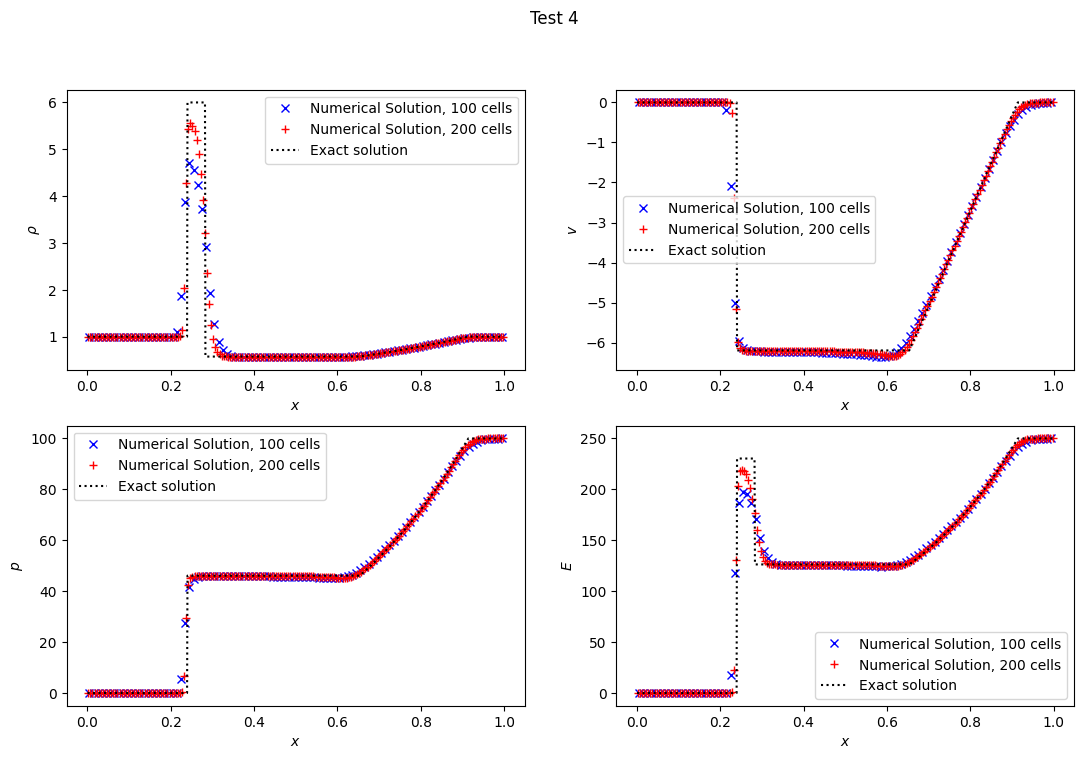

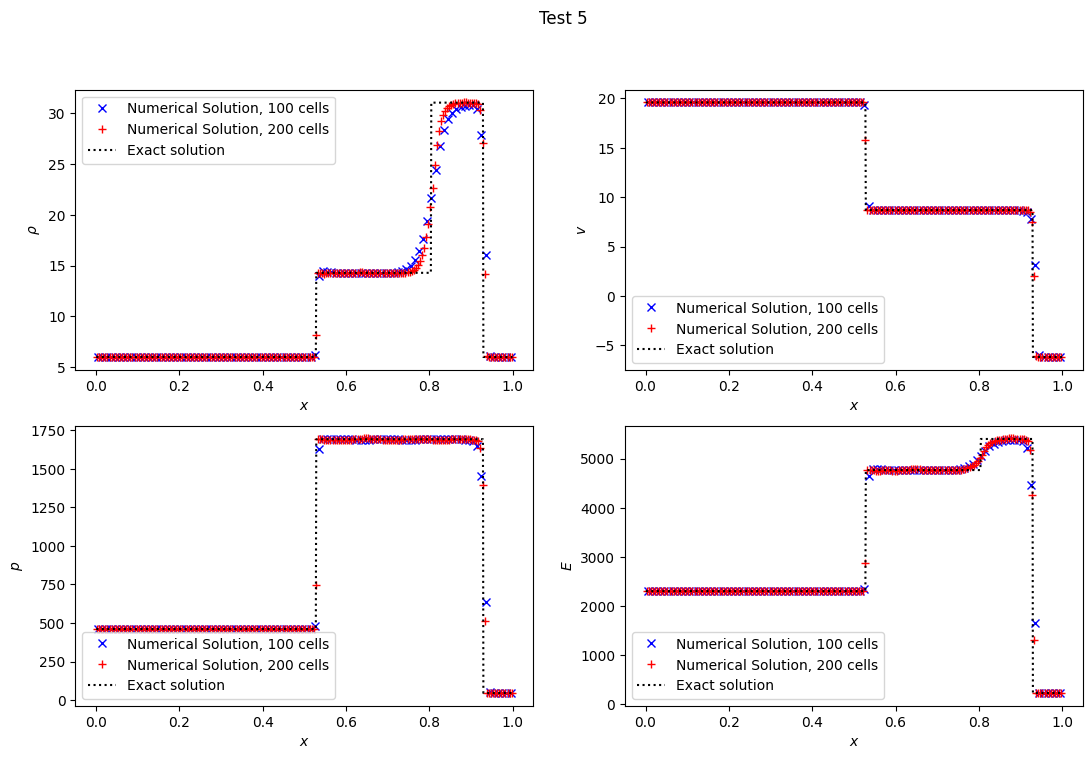

In [16]:
BASE_FILENAMES = [["./outputs/toro/muscl_hancock_100/test1/plt", "./outputs/toro/muscl_hancock_200/test1/plt"],
                  ["./outputs/toro/muscl_hancock_100/test2/plt", "./outputs/toro/muscl_hancock_200/test2/plt"],
                  ["./outputs/toro/muscl_hancock_100/test3/plt", "./outputs/toro/muscl_hancock_200/test3/plt"],
                  ["./outputs/toro/muscl_hancock_100/test4/plt", "./outputs/toro/muscl_hancock_200/test4/plt"],
                  ["./outputs/toro/muscl_hancock_100/test5/plt", "./outputs/toro/muscl_hancock_200/test5/plt"]]
FILENAMES = [[filename + "?????" for filename in subcase] for subcase in BASE_FILENAMES]
EXACT_SOLN_FILENAMES = [subcase[0] + "EXACT_SOLN" for subcase in BASE_FILENAMES]

adiabatic = 1.4

yt.set_log_level("error")
DIM = 1
to_plot = [0,1,2,3,4]
num_fmts = ["bx", "r+"]
for i in to_plot:
    subcase = FILENAMES[i]
    last_timestep_cases = []
    for FILENAME in subcase:
        ts = yt.load(FILENAME)
        last_timestep_cases.append(ts[-1])

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    for subcase_no, ds in enumerate(last_timestep_cases):
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            ray = ds.ray([x_centre,ds.domain_left_edge[1].value,0], [x_centre,ds.domain_right_edge[1].value,0])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        # time_label = f"t = {ds.current_time.value:.3f}"
        time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        num_fmt = num_fmts[subcase_no]
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    #
    # Plot exact solution
    #
    exact = yt.load(EXACT_SOLN_FILENAMES[i])
    ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    mom = np.array(ray["mom_x"])
    x = np.array(ray["x"])
    density = np.array(ray["density"])
    energy = np.array(ray["energy"])
    vel_x = mom / density
    pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    exact_label = "Exact solution"
    exact_fmt = "k:"

    ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()

/tmp/ipykernel_20932/456028912.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_20932/456028912.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


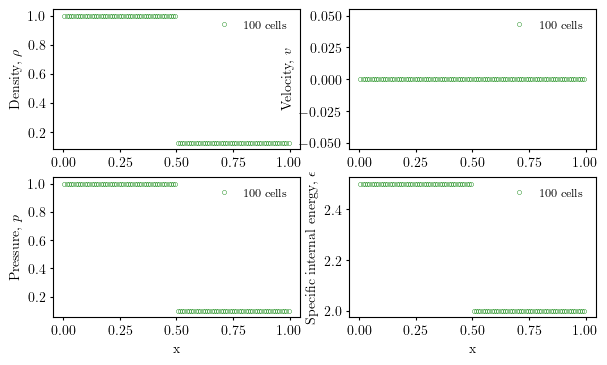

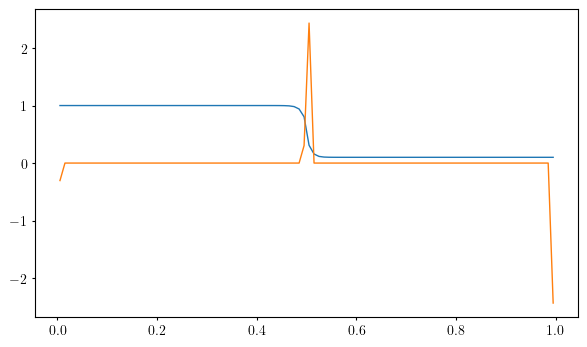

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(7,4))

# plot numerical solution
ds = yt.load("build/Exec/RiemannProblem/output/tmp/explicit")
label = f"{ds.domain_dimensions[0]} cells"

# ray
ray = get_ray(adiabatic, epsilon, rot, dim, ds)
plot_four(ray,ax,res_fmts[ifile],label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
format_axes(ax, "x")

fig.show()

fig, ax = plt.subplots(1,1,figsize=(7,4))
ds = yt.load("build/Exec/RiemannProblem/output/tmp/pressure")
pray = ds.ray([0,0,0],[1,0,0])
ax.plot(pray["x"],pray["pressure"])

fig.show()

dt = 0.006761234038
dx = 1/100

outdens = ray["density"]
outmom = ray["mom_x"] - 0.5 * dt / dx * (np.roll(ray["pressure"],-1) - np.roll(ray["pressure"],1))

plt.plot(ray["x"],outmom/outdens)
plt.show()